---
# Mobile-Net
-----

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import joblib
import math
import seaborn as sns


In [22]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

In [23]:
def img_resize(X_data, new_height, new_width, rgb= True):
    '''
        Overview:
        To resize input images to match network input layer.

        Arguments:
            - X_data: CNN model to inspect
            - new_height: input layer height
            - new_width: input layer width
            - rgb = True as default (RGB channels to 3 as default)

        Output:
            - Resized X_data
    '''
    # reshape to force X_data to have 4 dimenstions
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],-1)

    if rgb == True:
        # force X  to have three channels (RGB)
        X_rgb = np.repeat(X_data, 3, axis=-1) 
    else:
        pass

    # each image stored as single item in list
    resized_images = []
    for i in range(X_rgb.shape[0]):
        resized_image = tf.image.resize(X_rgb[i], size=[new_height,new_width],preserve_aspect_ratio=True )
        resized_images.append(resized_image)   
    
    # combines list of tensor items to single tensor item new dimenstion = num of images in list 
    X_resized = tf.stack(resized_images)
    
    return X_resized

In [24]:
X = joblib.load( '../../data/my_data/X.pkl')
y = joblib.load( '../../data/my_data/y.pkl')


In [25]:
X = X.reshape(-1,28,28)
X.shape

(34627, 28, 28)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [27]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255
# Sanity Check
print(f'X_train range: {X_train.min()}-{X_train.max()}')

X_train range: 0.0-1.0


In [28]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values, value_counts = np.unique(y, return_counts=True)

## Mobile Net Building
----

In [29]:
mobile_net = tf.keras.applications.MobileNet(input_shape=(128,128,3), # min size?
                                            alpha=1.0,
                                            depth_multiplier=1,
                                            dropout=0.001,
                                            include_top=False,
                                            weights="imagenet",
                                            classes=24,
                                            classifier_activation="softmax"
                                            )   

In [30]:
mobile_net.trainable = False

In [11]:
mobile_net.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         

### Adding my own top layers

In [12]:
my_model = Sequential([mobile_net,
                       layers.Flatten(),
                       layers.Dense(128, activation='relu'),
                       layers.Dense(64, activation="relu"),
                       layers.Dense(24, activation="softmax")
                       ])



In [13]:
my_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
Total params: 5,335,960
Trainable params: 2,107,096
Non-trainable params: 3,228,864
______________________________________

In [14]:
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [15]:
# Resize X_train and X_val to fit input dimesntions for VGG
X_train_resized = img_resize(X_train, 128, 128)
X_val_resized = img_resize(X_val, 128, 128)

In [16]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [17]:
history = my_model.fit(X_train_resized, y_train,
                        batch_size = 128,
                        epochs = 50,
                        verbose = 1,
                        validation_split = 0.2,
                        callbacks=[early_stop])

2024-07-09 14:49:10.593858: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50
174/174 [==============================] - 86s 478ms/step - loss: 0.3318 - accuracy: 0.9227 - val_loss: 0.0058 - val_accuracy: 0.9998
Epoch 2/50
174/174 [==============================] - 60s 345ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 3/50
174/174 [==============================] - 63s 361ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/50
174/174 [==============================] - 67s 386ms/step - loss: 6.3067e-04 - accuracy: 1.0000 - val_loss: 9.9080e-04 - val_accuracy: 1.0000
Epoch 5/50
174/174 [==============================] - 65s 376ms/step - loss: 3.6328e-04 - accuracy: 1.0000 - val_loss: 7.4487e-04 - val_accuracy: 1.0000
Epoch 6/50
174/174 [==============================] - 65s 374ms/step - loss: 2.4591e-04 - accuracy: 1.0000 - val_loss: 5.9428e-04 - val_accuracy: 1.0000
Epoch 7/50
174/174 [==============================] - 65s 372ms/step - loss: 1.8009e-04 - accuracy: 1.0000

In [18]:
my_model.save('../../model/my_models/mobile_net.h5')

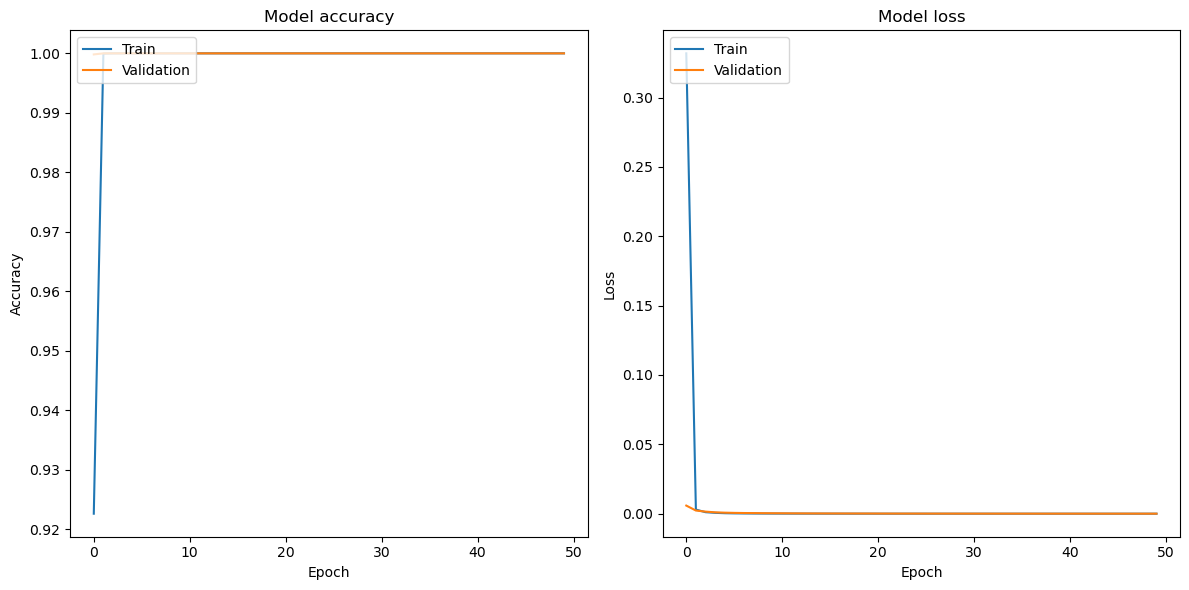

In [19]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [20]:
train_loss, train_acc = my_model.evaluate(X_train_resized, y_train)
print('Train accuracy:', train_acc)

866/866 [==============================] - 66s 76ms/step - loss: 4.7615e-06 - accuracy: 1.0000
Train accuracy: 1.0


In [34]:
# Evaluate the model's performance
val_loss, val_acc= my_model.evaluate(X_val_resized, y_val, verbose=1)
print('Val accuracy:', val_acc) 

217/217 [==============================] - 14s 63ms/step - loss: 3.7470e-04 - accuracy: 1.0000
Val accuracy: 1.0


## Fine Tuning
---

In [31]:
directory = '../../data/my_imgs/real_world_imgs/'
my_imgs = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True, 
    seed=1
)

Found 15819 files belonging to 24 classes.


In [32]:
train_data, val_data = keras.utils.split_dataset(my_imgs, right_size= 0.2)

In [33]:
for images, _ in train_data:
    images /=255

In [34]:
for images, _ in val_data:
    images /=255

In [35]:
# load the base VGG model
fine_tuned_mn = load_model('../../model/my_models/mobile_net.h5')

In [36]:
# only to unfreeze the last years of the base_vgg_model
for layer in fine_tuned_mn.layers[-4:]:
    print(layer)
    layer.trainable = True

In [37]:
# recompile the model
fine_tuned_mn.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [38]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           mode='min',
                           verbose=1)

In [39]:
history = fine_tuned_mn.fit(train_data,
                        batch_size = 128,
                        epochs = 20,
                        verbose = 1,
                        validation_data = val_data,
                        callbacks=[early_stop])

Epoch 1/20


396/396 [==============================] - 34s 84ms/step - loss: 0.3491 - accuracy: 0.9426 - val_loss: 0.0097 - val_accuracy: 0.9975
Epoch 2/20
396/396 [==============================] - 33s 85ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0020 - val_accuracy: 0.9997
Epoch 3/20
396/396 [==============================] - 33s 82ms/step - loss: 3.4065e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9997
Epoch 4/20
396/396 [==============================] - 33s 83ms/step - loss: 2.1352e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 0.9997
Epoch 5/20
396/396 [==============================] - 33s 84ms/step - loss: 1.5087e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 6/20
396/396 [==============================] - 34s 86ms/step - loss: 1.1115e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/20
396/396 [==============================] - 69s 174ms/step - loss: 8.3860e-05 - accuracy: 1.0000 - val_loss: 9.8022e-04 -

In [41]:
fine_tuned_mn.save('../../model/my_models/MobileNet_fine_tuned.h5')